## Song Embeddings - Skipgram Recommender

In this notebook, we'll use human-made music playlists to learn song embeddings. We'll treat a playlist as if it's a sentence and the songs it contains as words. We feed that to the word2vec algorithm which then learns embeddings for every song we have. These embeddings can then be used to recommend similar songs. This technique is used by Spotify, AirBnB, Alibaba, and others. It accounts for a vast portion of their user activity, user media consumption, and/or sales (in the case of Alibaba).

The [dataset we'll use](https://www.cs.cornell.edu/~shuochen/lme/data_page.html) was collected by Shuo Chen from Cornell University. The dataset contains playlists from hundreds of radio stations from around the US.

## Importing packages and dataset

In [24]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import Word2Vec
from urllib import request
import warnings
warnings.filterwarnings('ignore')

The playlist dataset is a text file where every line represents a playlist. That playlist is basically a series of song IDs.

In [25]:
# Get the playlist dataset file
data = request.urlopen('https://storage.googleapis.com/maps-premium/dataset/yes_complete/train.txt')

# Parse the playlist dataset file. Skip the first two lines as
# they only contain metadata
lines = data.read().decode("utf-8").split('\n')[2:]

# Remove playlists with only one song
playlists = [s.rstrip().split() for s in lines if len(s.split()) > 1]


The `playlists` variable now contains a python list. Each item in this list is a playlist containing song ids. We can look at the first two playlists here:

In [26]:
print( 'Playlist #1:\n ', playlists[0], '\n')
print( 'Playlist #2:\n ', playlists[1])

Playlist #1:
  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '2', '42', '43', '44', '45', '46', '47', '48', '20', '49', '8', '50', '51', '52', '53', '54', '55', '56', '57', '25', '58', '59', '60', '61', '62', '3', '63', '64', '65', '66', '46', '47', '67', '2', '48', '68', '69', '70', '57', '50', '71', '72', '53', '73', '25', '74', '59', '20', '46', '75', '76', '77', '59', '20', '43'] 

Playlist #2:
  ['78', '79', '80', '3', '62', '81', '14', '82', '48', '83', '84', '17', '85', '86', '87', '88', '74', '89', '90', '91', '4', '73', '62', '92', '17', '53', '59', '93', '94', '51', '50', '27', '95', '48', '96', '97', '98', '99', '100', '57', '101', '102', '25', '103', '3', '104', '105', '106', '107', '47', '108', '109', '110', '111', '112', '113', '25', '63', '62', '114', '115', '84', '116', '117',

## Training the Word2Vec Model
Our dataset is now in the shape the the Word2Vec model expects as input. We pass the dataset to the model.

In [27]:
model = Word2Vec(playlists, vector_size=32, window=20, negative=50, min_count=1, workers=4)

The model is now trained. Every song has an embedding. We only have song IDs, though, no titles or other info. Let's grab the song information file.

## Song Title and Artist File
Let's load and parse the file containing song titles and artists

In [28]:
songs_file = request.urlopen('https://storage.googleapis.com/maps-premium/dataset/yes_complete/song_hash.txt')
songs_file = songs_file.read().decode("utf-8").split('\n')
songs = [s.rstrip().split('\t') for s in songs_file]

In [29]:
songs_df = pd.DataFrame(data=songs, columns = ['id', 'title', 'artist'])
songs_df = songs_df.set_index('id')

In [30]:
songs_df.head()

,title,artist
id,,
0,Gucci Time (w\/ Swizz Beatz),Gucci Mane
1,Aston Martin Music (w\/ Drake & Chrisette Mich...,Rick Ross
2,Get Back Up (w\/ Chris Brown),T.I.
3,Hot Toddy (w\/ Jay-Z & Ester Dean),Usher
4,Whip My Hair,Willow


### Exercise:

Build visualization for the embeddings of the song recommender.

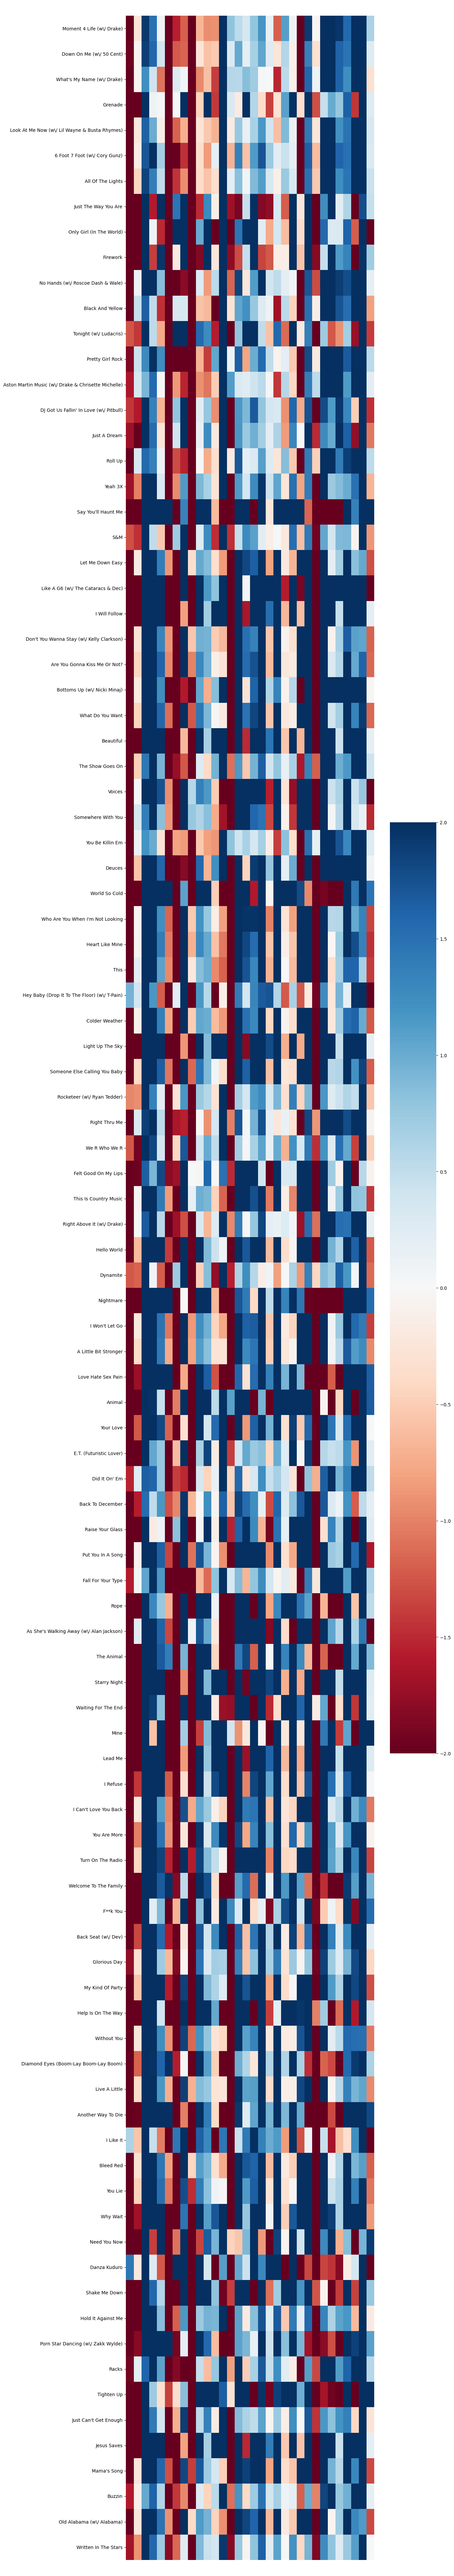

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_embeddings(vectors, labels=None):
    n_vectors = len(vectors)
    fig = plt.figure(figsize=(12, n_vectors))
    ax = plt.gca()

    # Visualización de los vectores de embedding usando un heatmap
    sns.heatmap(vectors, cmap='RdBu', vmax=2, vmin=-2, ax=ax)


    if labels:
        ax.set_yticklabels(labels, rotation=0)
        ax.tick_params(axis='both', which='major', labelsize=10)


    plt.tick_params(axis='x', which='both',  bottom=False, top=False, labelbottom=False)


    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()


# Limpiar los espacios en los identificadores del DataFrame songs_df
songs_df.index = songs_df.index.str.strip()  # Elimina espacios en blanco de los identificadores

# Usar los embeddings y los títulos para las primeras 100 canciones
vectors = model.wv.vectors

# Crear una lista de títulos solo si el id de la canción existe en songs_df
labels = []
for song_id in model.wv.index_to_key[:100]:
    if song_id in songs_df.index:
        labels.append(songs_df.loc[song_id, 'title'])
    else:
        labels.append('Unknown')


plot_embeddings(vectors[:100], labels[:100])

In [32]:

print("IDs en el modelo Word2Vec (primeros 10):", model.wv.index_to_key[:10])
print("IDs en el DataFrame songs_df (primeros 10):", songs_df.index[:10])
print("Tipo de ID en el modelo Word2Vec:", type(model.wv.index_to_key[0]))
print("Tipo de ID en el DataFrame songs_df:", type(songs_df.index[0]))

IDs en el modelo Word2Vec (primeros 10): ['20065', '5', '46', '7233', '20627', '19477', '20068', '60', '82', '9659']
IDs en el DataFrame songs_df (primeros 10): Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='object', name='id')
Tipo de ID en el modelo Word2Vec: <class 'str'>
Tipo de ID en el DataFrame songs_df: <class 'str'>


In [33]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def get_similar_songs_clusters(model, keys, topn=30):

    embedding_clusters = []
    song_clusters = []

    # Agrupar canciones similares
    for song in keys:
        embeddings = []
        songs = []
        for similar_song, _ in model.wv.most_similar(song, topn=topn):
            songs.append(similar_song)
            embeddings.append(model.wv[similar_song])
        embedding_clusters.append(embeddings)
        song_clusters.append(songs)

    return np.array(embedding_clusters), song_clusters


def visualize_song_clusters_with_tsne(model, songs_df, topn=30, perplexity=5, n_components=2, n_iter=1500, random_state=42, learning_rate=200):


    # Seleccionar un conjunto de canciones "clave" para encontrar sus similares
    keys = model.wv.index_to_key[:10]  # Tomar las primeras 10 canciones como claves para agrupar

    # Obtener los embeddings y clusters de canciones similares
    embedding_clusters, song_clusters = get_similar_songs_clusters(model, keys, topn)

    # Obtener las dimensiones para aplicar t-SNE
    n, m, k = embedding_clusters.shape

    # Aplicar t-SNE para reducir dimensiones a 2D
    tsne_model = TSNE(perplexity=perplexity, n_components=n_components, n_iter=n_iter, learning_rate=learning_rate, random_state=random_state)
    embeddings_2d = np.array(tsne_model.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


    plt.figure(figsize=(16, 9))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(song_clusters)))

    # Visualizar clusters de canciones
    for i, (embeddings, songs, color) in enumerate(zip(embeddings_2d, song_clusters, colors)):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, label=f'Cluster {i+1}', color=color, alpha=0.6, s=100)

        for j, song_id in enumerate(songs):
            title = songs_df.loc[song_id, 'title'] if song_id in songs_df.index else 'Unknown'
            plt.annotate(title, alpha=0.7, xy=(x[j], y[j]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8, color=color)


    plt.legend(loc='best')
    plt.grid(True)
    plt.title('t-SNE Visualization of Song Clusters', fontsize=14)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

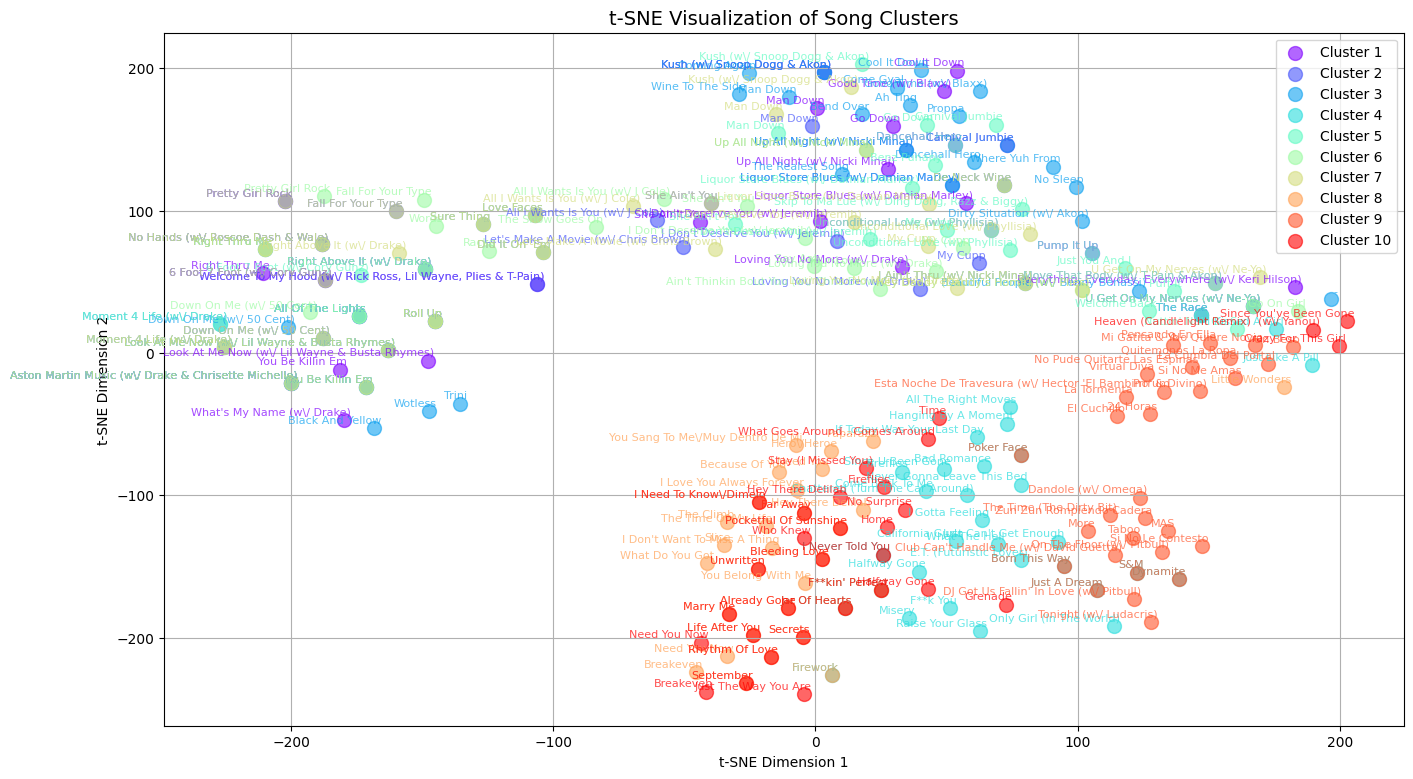

In [34]:
visualize_song_clusters_with_tsne(
    model=model,         # Modelo Word2Vec entrenado
    songs_df=songs_df,   # DataFrame con las canciones
    topn=30,             # Recuperar las 30 canciones más similares
    perplexity=40,       # Ajustar el parámetro de t-SNE
    n_iter=1500,         # Número de iteraciones de t-SNE
    learning_rate=100    # Ajustar la tasa de aprendizaje de t-SNE
)